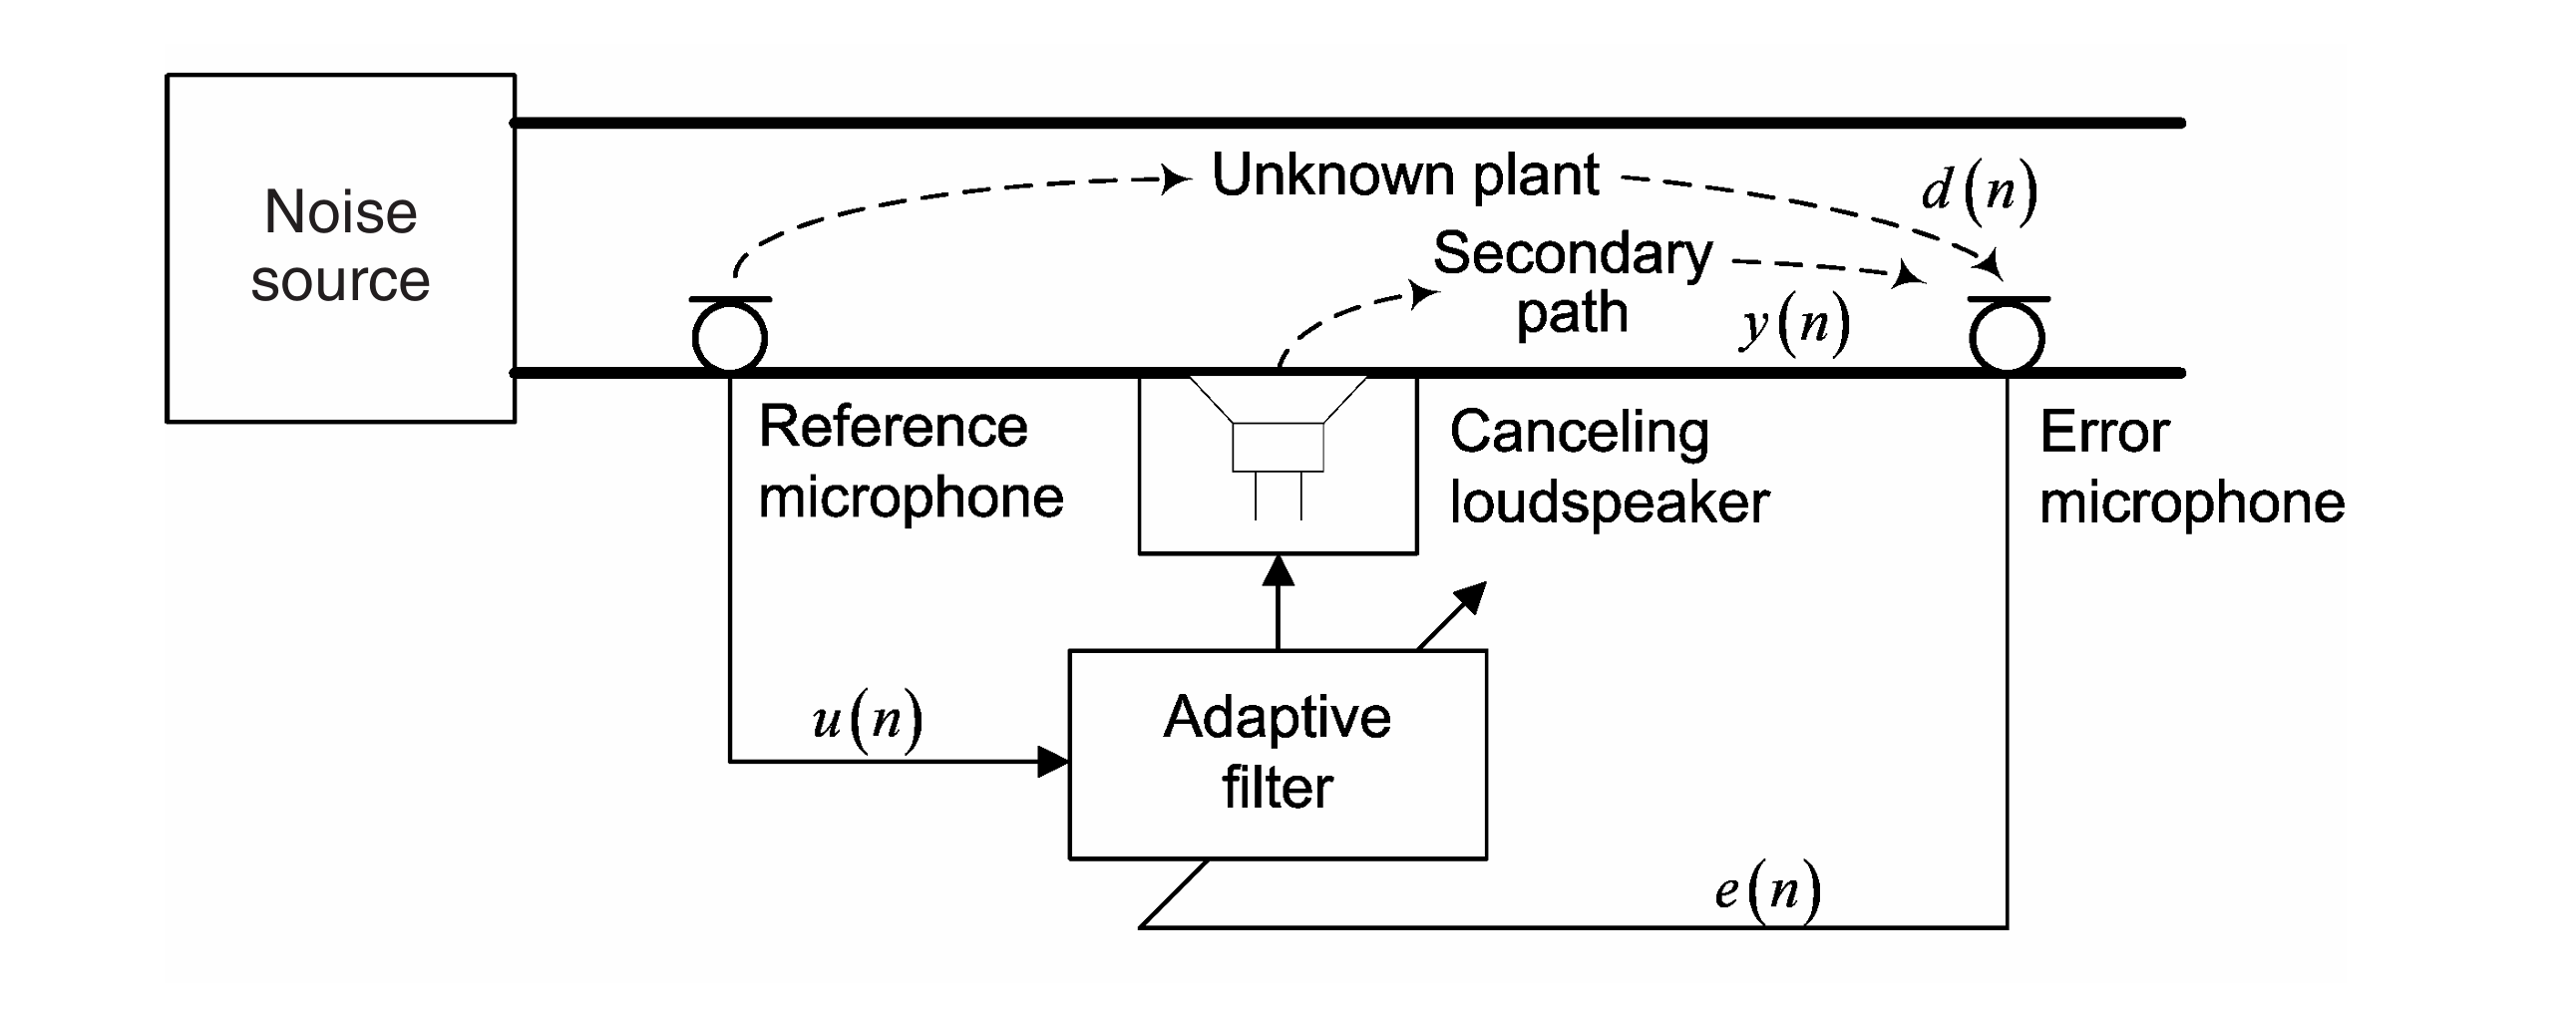

In [1]:
## This main function is folked from https://github.com/Luo-Zhengding/SFANC-FxNLMS-ANC-Algorithm-based-on-Deep-Learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tools import generate_bandpass_wn, loading_paths_from_MAT
from plot_tools import WaveVisualizer
import scipy.signal as signal
import progressbar
from generating_Disturbance import Disturbance_generation_from_real_noise


In [2]:
## Initialize the parameters
# Length of the filter
M = 256
# Learning rate
muw = 0.005
# Sample rate
fs = 48000
# Simulation time
t = 10
# Total length of the input data
N = fs * t

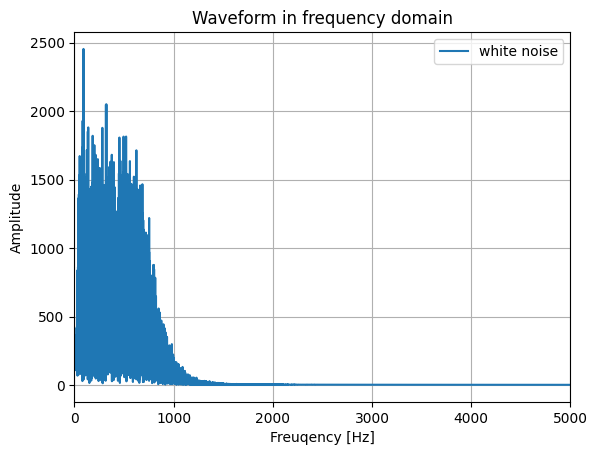

In [3]:
# Generate the white noise which has frequency components in [30Hz,800Hz]
x_wn = generate_bandpass_wn(N, fs, 30, 800)
Plot_wn = WaveVisualizer(x_wn, fs, 'white noise')
Plot_wn.plot_frequency_domain()

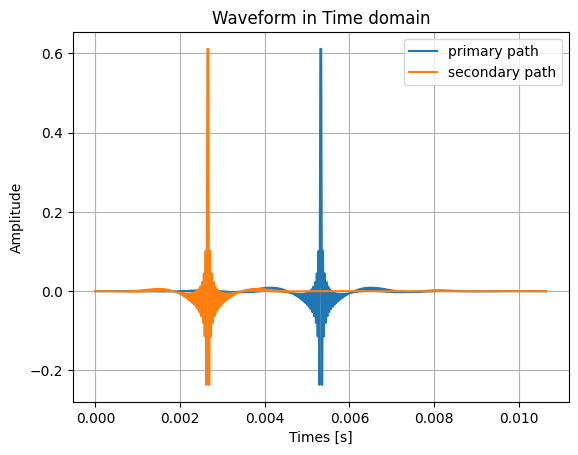

In [4]:
# Load the impulse response of primary path and secondary path
pri_path, sec_path = loading_paths_from_MAT()
sec_path = np.concatenate([sec_path, np.zeros(M)])
Plot_pri = WaveVisualizer(pri_path, fs, 'primary path')
Plot_sec = WaveVisualizer(sec_path, fs, "secondary path")
Plot_pri.plot_time_domain()
Plot_sec.plot_time_domain()


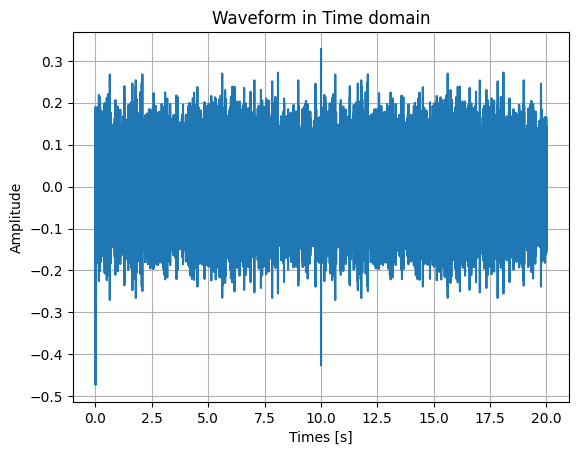

In [5]:
## Generate the disturbance and reference signal
Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=1, wave_from=x_wn, Pri_path=pri_path, Sec_path=sec_path)
Plot_dis = WaveVisualizer(Dis,fs)
Plot_dis.plot_time_domain()

In [6]:
class FxLMS():
    def __init__(self, len):
        self.Wc = torch.zeros(1, len, requires_grad=True, dtype=torch.float)
        self.Xd = torch.zeros(1, len, dtype=torch.float)

    def feedforward(self, Xf):
        self.Xd = torch.roll(self.Xd, 1, 1)
        self.Xd[0, 0] = Xf
        yt = self.Wc @ self.Xd.t()
        return yt
    
    def lossfunction(self, y, d):
        e = d - y
        return e ** 2, e
    
    def _get_coeff_(self):
        return self.Wc.detach().numpy()
    
def train_fxlms(Model, Ref, Disturbance, Stepsize=0.0001):
    bar = progressbar.ProgressBar(maxval=2*Disturbance.shape[0],\
                                  widgets = [progressbar.Bar('=','[',']'),' ', progressbar.Percentage()])
    optimizer = optim.SGD([Model.Wc], lr=Stepsize)
    bar.start()
    Error_signal = []
    len_data = Disturbance.shape[0]
    for iter in range(len_data):
        # feedforward
        xin = Ref[iter]
        dis = Disturbance[iter]
        y = Model.feedforward(xin)
        loss, e = Model.lossfunction(y, dis)

        bar.update(2*iter+1)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Error_signal.append(e.item())

        bar.update(2*iter+2)
    bar.finish()
    return Error_signal

In [7]:
# FxLMS to control noise
controller = FxLMS(len=M)
Error = train_fxlms(Model=controller, Ref=Fx, Disturbance=Dis, Stepsize=muw)

[                                                                        ]   0%
[                                                                        ]   1%
[=                                                                       ]   2%
[==                                                                      ]   3%
[===                                                                     ]   5%
[====                                                                    ]   6%
[=====                                                                   ]   7%
[======                                                                  ]   8%
[=======                                                                 ]  10%
[========                                                                ]  11%
[=========                                                               ]  12%
[==========                                                              ]  13%
[==========                             

The SPL is 70.38 dB
The SPL is 33.14 dB


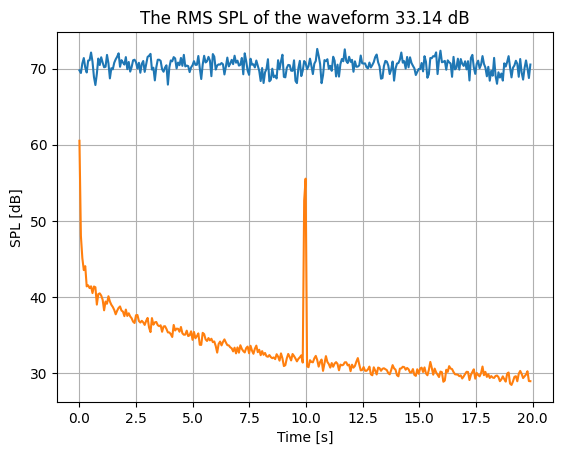

In [9]:
Plot_Error = WaveVisualizer(np.array(Error),fs)
Plot_dis.plot_RMS_SPL()
Plot_Error.plot_RMS_SPL()


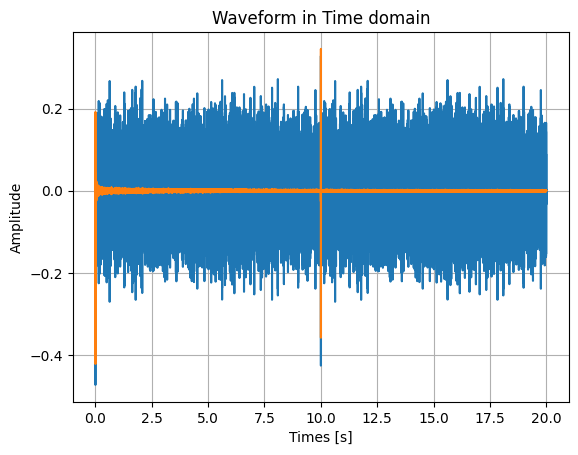

In [10]:

Plot_dis.plot_time_domain()
Plot_Error.plot_time_domain()